<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2022/MLE_Fisher_Info_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip -q install jaxopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 KB 5.5 MB/s eta 0:00:00


In [3]:
import time
import functools
from functools import partial
# JAX library : une nouvelle venue dans le domaine 
#       l'auto-differentiation
#       la compilation Just-In-Time 
#       l'optilisation XLA du code compile pour le device CPU/GPU/TPU

import jax
import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap, value_and_grad
from jax.example_libraries import optimizers

from jax.config import config
config.update("jax_enable_x64", True)

# Optimization library based on JAX (eg standard Gradient Desceant)
import jaxopt

# Numpy 
import numpy as np

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
#plt.style.use('seaborn-paper')
#mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18
from matplotlib.patches import Ellipse

In [26]:
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\cdot10^{{{1:d}}}$".format(coeff, exponent, precision)

# The MLE is optimal wrt Fisher Information

In [36]:
param_true = 1.0  # The true parameter that we want to get from MLE
sample_size = 1_000
sigma_e = 0.1      # sdt error on y 
key = jax.random.PRNGKey(1) # key for random generator


In [37]:
# The model  y = mu_\theta(x) = theta * x^3
@jit
def model(param, X):
    return param * X**3


In [54]:
# Generation of dataset samples
@partial(jit, static_argnums=1)
def gen_spl(key, p):
    key, key1,key2 = jax.random.split(key,3)
    xi = jax.random.uniform(key1, shape=(sample_size,), minval=-1,maxval=1) # input X
    noise = sigma_e * jax.random.normal(key2, shape=(sample_size,))
    yi = model(p,xi)  + noise  # add white noise to the target y
    return key,xi,yi


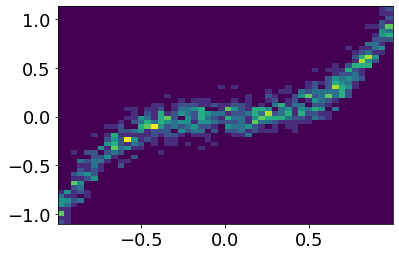

In [55]:
_,x0,y0 = gen_spl(key, param_true)
plt.hist2d(x0,y0,bins=50);


In [40]:
Cov_inv = jnp.eye(sample_size)/sigma_e**2  # Sigma^-1

In [133]:
def loss(p, X, y):
    """ MSE loss """
    residuals = model(p,X) - y
    return jnp.mean(residuals ** 2)


In [134]:
# Setup the GD minimizer
gd = jaxopt.GradientDescent(fun=loss, tol=1e-6)


In [138]:
@partial(jit, static_argnums=1)
def func(seed,p):
    key = jax.random.PRNGKey(seed)
    key,X,y = gen_spl(key, p)   # new dataset
    key, key_ini = jax.random.split(key)
    init_params = jax.random.uniform(key_ini, minval=-10, maxval=10) # initialize the paramter
    return gd.run(init_params, X=X, y=y).params   # do the GD minimization


In [139]:
# Parallelization on seed (not on p_true)
parallel_func = jax.vmap(func, in_axes=(0, None))


In [140]:
# Get K independant GD minimisation
K = 10_000
seeds = jnp.arange(0,K)
res = np.array(parallel_func(seeds,param_true))


# Compute Fisher Information matrix

$$
F_{\alpha\beta} = \sum_i \frac{\partial y_i}{\partial \theta_\alpha}^T \Sigma^{-1}\frac{\partial y_i}{\partial \theta_\beta}
$$

In [117]:
jacobian = jax.jit(jax.jacfwd(lambda p: model(p, X=x0).flatten()))   # dy/dtheta

j = jacobian(param_true)[:,jnp.newaxis]


In [119]:
F1 = j.T @ Cov_inv @ j # jnp.einsum('ia,ij,jb',j,Cov_inv,j)

In [141]:
# Here inversion of the Fisher Info is simple, overwise jnp.linalg.inv(Fisher)
Fisher_inv = 1/Fisher[0][0]
std_set = np.sqrt(Fisher_inv)


In [143]:
def gauss(x, scale):
    return jax.scipy.stats.norm.pdf(x,scale=scale)

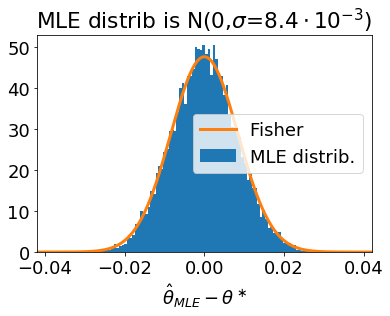

In [144]:
plt.hist(res-param_true, bins=100, density=True, label="MLE distrib.");

x_axis = np.arange(-5*std_set, 5*std_set, std_set/100)
plt.plot(x_axis,gauss(x_axis, std_set),lw=3, label=fr"Fisher ")
plt.title(fr"MLE distrib is N(0,$\sigma$={sci_notation(std_set)})")
plt.xlabel(r"$\hat{\theta}_{MLE} - \theta^\ast$")
plt.xlim([-5*std_set, 5*std_set])
plt.legend();
